## Gaussian Process Modeling on Single Metabolite 
### Author: Allen Ross
### Date: 01/18/2021

#### Overview
In this notebook we will be examining a single metabolite measured during the iHMP (also known as HMP2) Inflammatory Bowel Disease (IBD) study (https://www.ibdmdb.org) using Gaussian Processes (GPs). 

In [11]:
# Setup

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist

# Options
sns.set(rc={'figure.figsize':(10,7)})

#### Data Preparation
Read in and prepare the data. The available data can be downloaded [here](https://ibdmdb.org/tunnel/public/summary.html). 

In [2]:
# Read in metabolomics data
mbx = pd.read_csv('../../../hmp2/data/seq/ibdmdb/public/HMP2/Metabolites/1723/HMP2_metabolomics.csv')

# Read in metadata for timing of samples
meta = pd.read_csv('../../../hmp2/data/hmp2_metadata.csv')

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Check data and pull off one metabolite for an exercise
mb = mbx.iloc[0,7:]
mb.head(10)

HSM5FZBJ    4.35547e+06
MSM5FZ9X    2.62384e+06
CSM5FZ3N         942546
ESM5MEDZ    5.75912e+06
MSM5FZA2    2.23142e+06
MSM5LLHZ         913814
HSM5FZBQ    1.97614e+06
MSM5LLIC    2.32295e+06
MSM5LLIG     1.3556e+06
CSM5FZ3T         470132
Name: 0, dtype: object

In [4]:
# Subset metadata to appropriate samples and columns of interest
meta = meta[meta['External ID'].isin(mb.index)][['External ID', 'Participant ID', 
                                                 'date_of_receipt', 'diagnosis']]
meta.set_index('External ID', inplace = True)

In [5]:
# Merge metabolomics info to metadata
df = (meta.merge(mb, left_index = True, 
           right_index = True).
      drop_duplicates().
      rename(columns = {'Participant ID': 'id',
                        'date_of_receipt': 'date',
                        0: 'intensity'}))

# Fix the date column
df.date = pd.to_datetime(df.date)

In [6]:
# Now scale the dates compared to the earliest date
min_date = df.date.min()
df['days_from_start'] = (df.date - min_date).dt.days

# Make sure that intensities are numeric
df.intensity = df.intensity.astype('double')

# Then calculate the log of the intensities
df['log_intensity'] = np.log(df.intensity)

# Finally standardize the log values
log_intensity_mean = df.log_intensity.mean()
log_intensity_sd = df.log_intensity.std()
df['scaled_log_intensity'] = (df.log_intensity - log_intensity_mean)/log_intensity_sd
df.head()

,id,date,intensity,days_from_start,log_intensity,scaled_log_intensity
CSM5FZ3N,C3001,2014-03-14,942546.0,93,13.756340,-0.409704
CSM5FZ3T,C3002,2014-04-29,470132.0,139,13.060769,-1.244306
CSM5FZ44,C3002,2014-06-24,720369.0,195,13.487519,-0.732257
CSM5FZ48,C3003,2014-05-08,1069292.0,148,13.882507,-0.258318
CSM5FZ4A,C3004,2014-05-13,1265301.0,153,14.050821,-0.056363


#### Data Visualization

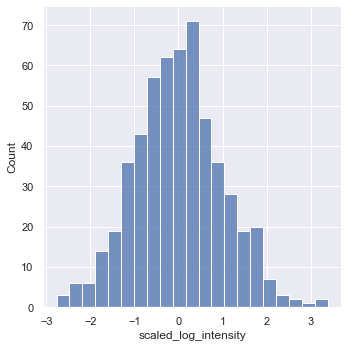

In [12]:
# Plot scaled transformed data
sns.displot(data = df,
            x = 'scaled_log_intensity');

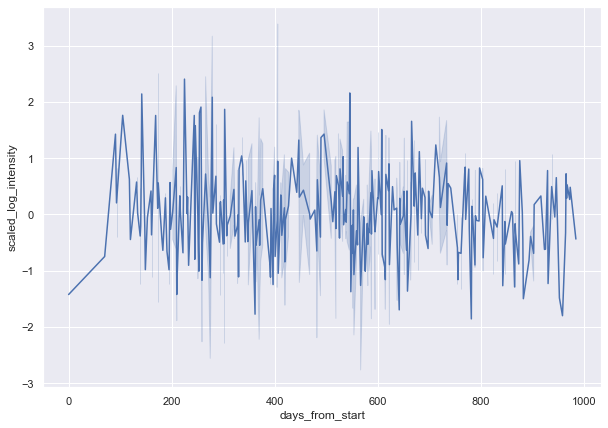

In [13]:
# Plot data along study time
sns.lineplot(data = df,
             x = 'days_from_start',
             y = 'scaled_log_intensity');

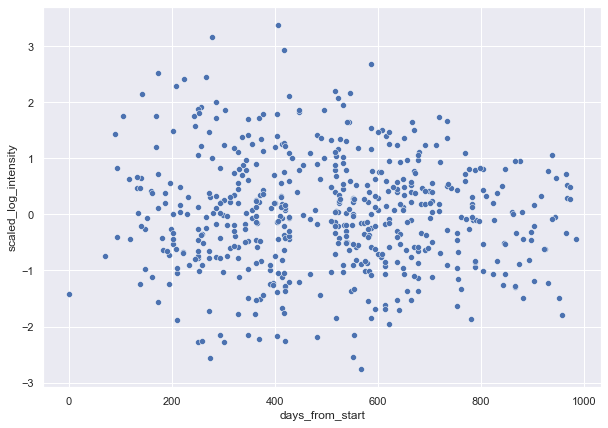

In [66]:
# Plot data for a subset of IDs
num_ids = 106
df_sub_id = df[df.id.isin(df.id.unique()[:num_ids])]
sns.scatterplot(data = df_sub_id,
                x = 'days_from_start',
                y = 'scaled_log_intensity');

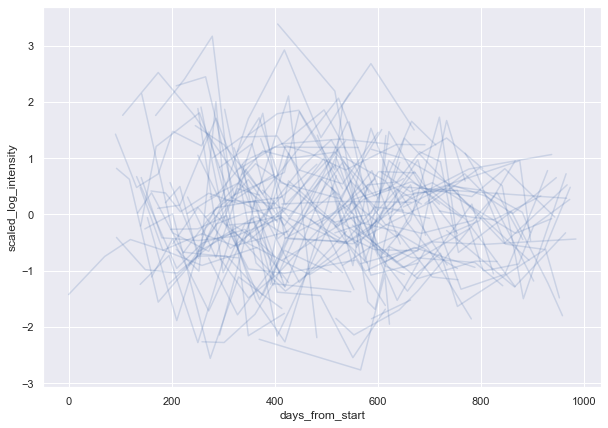

In [67]:
sns.lineplot(data = df_sub_id,
             x = 'days_from_start',
             y = 'scaled_log_intensity',
             units = 'id',
             estimator = None,
             alpha = 0.2);

In [68]:
# Modify data to creat dummies
df_sub = pd.get_dummies(df_sub_id[['id', 'days_from_start', 'scaled_log_intensity']],
                        drop_first = True)
df_sub.days_from_start = (df_sub.days_from_start - df_sub.days_from_start.mean())/df_sub.days_from_start.std()

In [69]:
# Take a look at the dimensions and a sample of rows
print(df_sub.shape)
df_sub.head()

(546, 107)


,days_from_start,scaled_log_intensity,id_C3002,id_C3003,id_C3004,id_C3005,id_C3006,id_C3008,id_C3009,id_C3010,...,id_P6016,id_P6017,id_P6018,id_P6024,id_P6025,id_P6028,id_P6033,id_P6035,id_P6037,id_P6038
CSM5FZ3N,-1.958183,-0.409704,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CSM5FZ3T,-1.740214,-1.244306,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CSM5FZ44,-1.474862,-0.732257,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CSM5FZ48,-1.697568,-0.258318,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CSM5FZ4A,-1.673876,-0.056363,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we will fit a simple squared exponential Gaussian process model with only time and individual, output being metabolite intensity.

In [70]:
# Specify simple model
with pm.Model() as mtx_model:
    
    # Squared exponential kernel parameters
    l_day = pm.Lognormal('l_day', 
                         mu = 0, 
                         sigma = 1)
    s2_f_se = pm.Lognormal('s2_f_se', 
                           mu = 0,
                           sigma = 1)
    
#     # Linear covariance pattern prior
#     c = pm.Normal('c', mu = 0, tau = 1)

#     # Periodicity variance priors
# #     period = pm.HalfNormal('period', tau = 0.5)
# #     l_period = pm.HalfNormal('l_period', tau = 0.5)
#     period = pm.Lognormal('period', mu = 0, sigma = 1)
#     l_period = pm.Lognormal('l_period', mu = 0, sigma = 1)
    
    
    # Covariance over individuals
    l_id = pm.Lognormal('l_id', 
                        mu = 0, 
                        sigma = 1)#, 
#                         shape = num_ids-1)
    s2_f_id = pm.Lognormal('s2_f_id',
                           mu = 0,
                           sigma = 1)

    # Function covariance equation
    f_cov = (s2_f_se*pm.gp.cov.ExpQuad(df_sub.shape[1]-1, 
                                       l_day, 
                                       active_dims = [0]) + 
             
#              s2_f[1]*pm.gp.cov.Linear(df_sub.shape[1]-1, c, active_dims = [0]) + 
              
#              s2_f[2]*pm.gp.cov.Periodic(df_sub.shape[1]-1, period = period, 
#                                         ls = l_period, active_dims = [0]) + 
             
             s2_f_id*pm.gp.cov.ExpQuad(df_sub.shape[1]-1, 
                                       l_id, 
                                       active_dims = np.arange(num_ids-1)+1))
    
    # Specify GP marginal
    gp = pm.gp.Marginal(cov_func = f_cov)
    
    # Noise variance prior
    s2_n = pm.Lognormal('s2_n', 
                        mu = 0, 
                        sigma = 1)
    
    # List observed information
    y_obs = gp.marginal_likelihood('y_obs',
                                   noise=s2_n, 
                                   X = df_sub.drop(columns = ['scaled_log_intensity']).to_numpy(),
                                   y = df_sub.scaled_log_intensity[:, None].squeeze())

In [71]:
# Compute MAP
mp = pm.find_MAP(model = mtx_model)

In [31]:
mp

{'l_day_log__': array(-0.19851024),
 's2_f_se_log__': array(-1.80143272),
 'l_id_log__': array([-0.84773599, -0.83318597, -0.97191887, -0.88747374, -1.04912993,
        -0.98735792, -1.08118288, -1.02670618, -0.73203541]),
 's2_f_id_log__': array(-0.57828458),
 's2_n_log__': array(0.02930823),
 'l_day': array(0.81995137),
 's2_f_se': array(0.16506223),
 'l_id': array([0.4283837 , 0.43466226, 0.37835633, 0.41169449, 0.35024235,
        0.37255972, 0.33919406, 0.35818481, 0.48092911]),
 's2_f_id': array(0.56085965),
 's2_n': array(1.02974194)}

In [72]:
# Print MAP
mp

{'l_day_log__': array(0.03886662),
 's2_f_se_log__': array(-2.21601311),
 'l_id_log__': array(-1.00043523),
 's2_f_id_log__': array(-0.96019304),
 's2_n_log__': array(-0.23604372),
 'l_day': array(1.03963181),
 's2_f_se': array(0.10904299),
 'l_id': array(0.36771936),
 's2_f_id': array(0.38281898),
 's2_n': array(0.78974614)}

Now we would like to view the posterior MAP over time. 

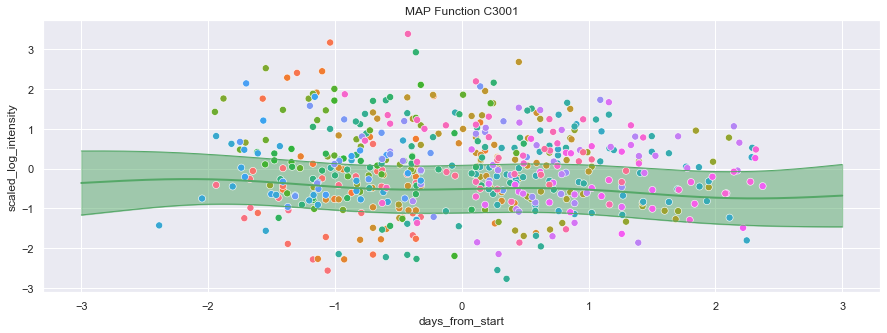

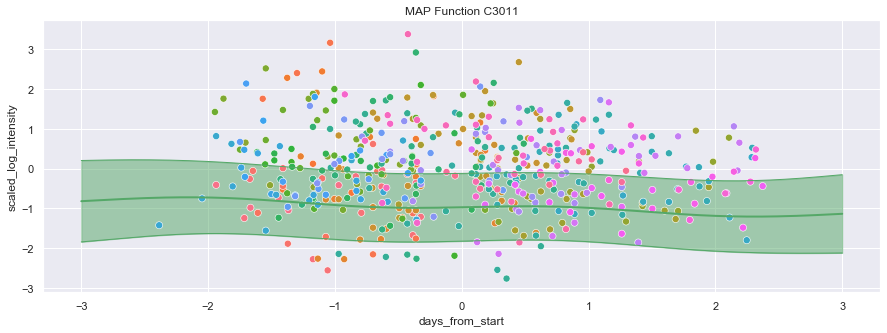

In [61]:
# Predict values across time, assume we are looking at the first id
# X_new = np.linspace(0, 1000, 200)[:, None]
X_new = np.vstack([np.linspace(-3, 3, 200), 
#                  np.repeat(1, 200),
                 np.zeros(shape = (num_ids-1, 200))]).T

# Plot posterior from MAP 
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# Set up figure
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot mean +/- 2 SD
plt.plot(X_new[:,0], mu, "g", lw=2, label="mean and 2σ region")
plt.plot(X_new[:,0], mu + 2 * sd, "g", lw=1)
plt.plot(X_new[:,0], mu - 2 * sd, "g", lw=1)
plt.fill_between(X_new[:,0].flatten(), mu - 2 * sd, mu + 2 * sd, color="g", alpha=0.5)
plt.title('MAP Function C3001');
# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                legend = False,
                s = 50);

X_new2 = np.vstack([np.linspace(-3, 3, 200), 
                    np.zeros(shape = (num_ids-2, 200)),
                    np.repeat(1, 200)]).T

# Plot posterior from MAP 
mu, var = gp.predict(X_new2, point=mp, diag=True)
sd = np.sqrt(var)

# Set up figure
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()

# Plot mean +/- 2 SD
plt.plot(X_new[:,0], mu, "g", lw=2, label="mean and 2σ region")
plt.plot(X_new[:,0], mu + 2 * sd, "g", lw=1)
plt.plot(X_new[:,0], mu - 2 * sd, "g", lw=1)
plt.fill_between(X_new[:,0].flatten(), mu - 2 * sd, mu + 2 * sd, color="g", alpha=0.5)
plt.title('MAP Function C3011');
# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                legend = False,
                s = 50);

In [75]:
with mtx_model:
    meanfield = pm.fit(method="advi")

Finished [100%]: Average Loss = 742


/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa08b14a220>,
      dtype=object)

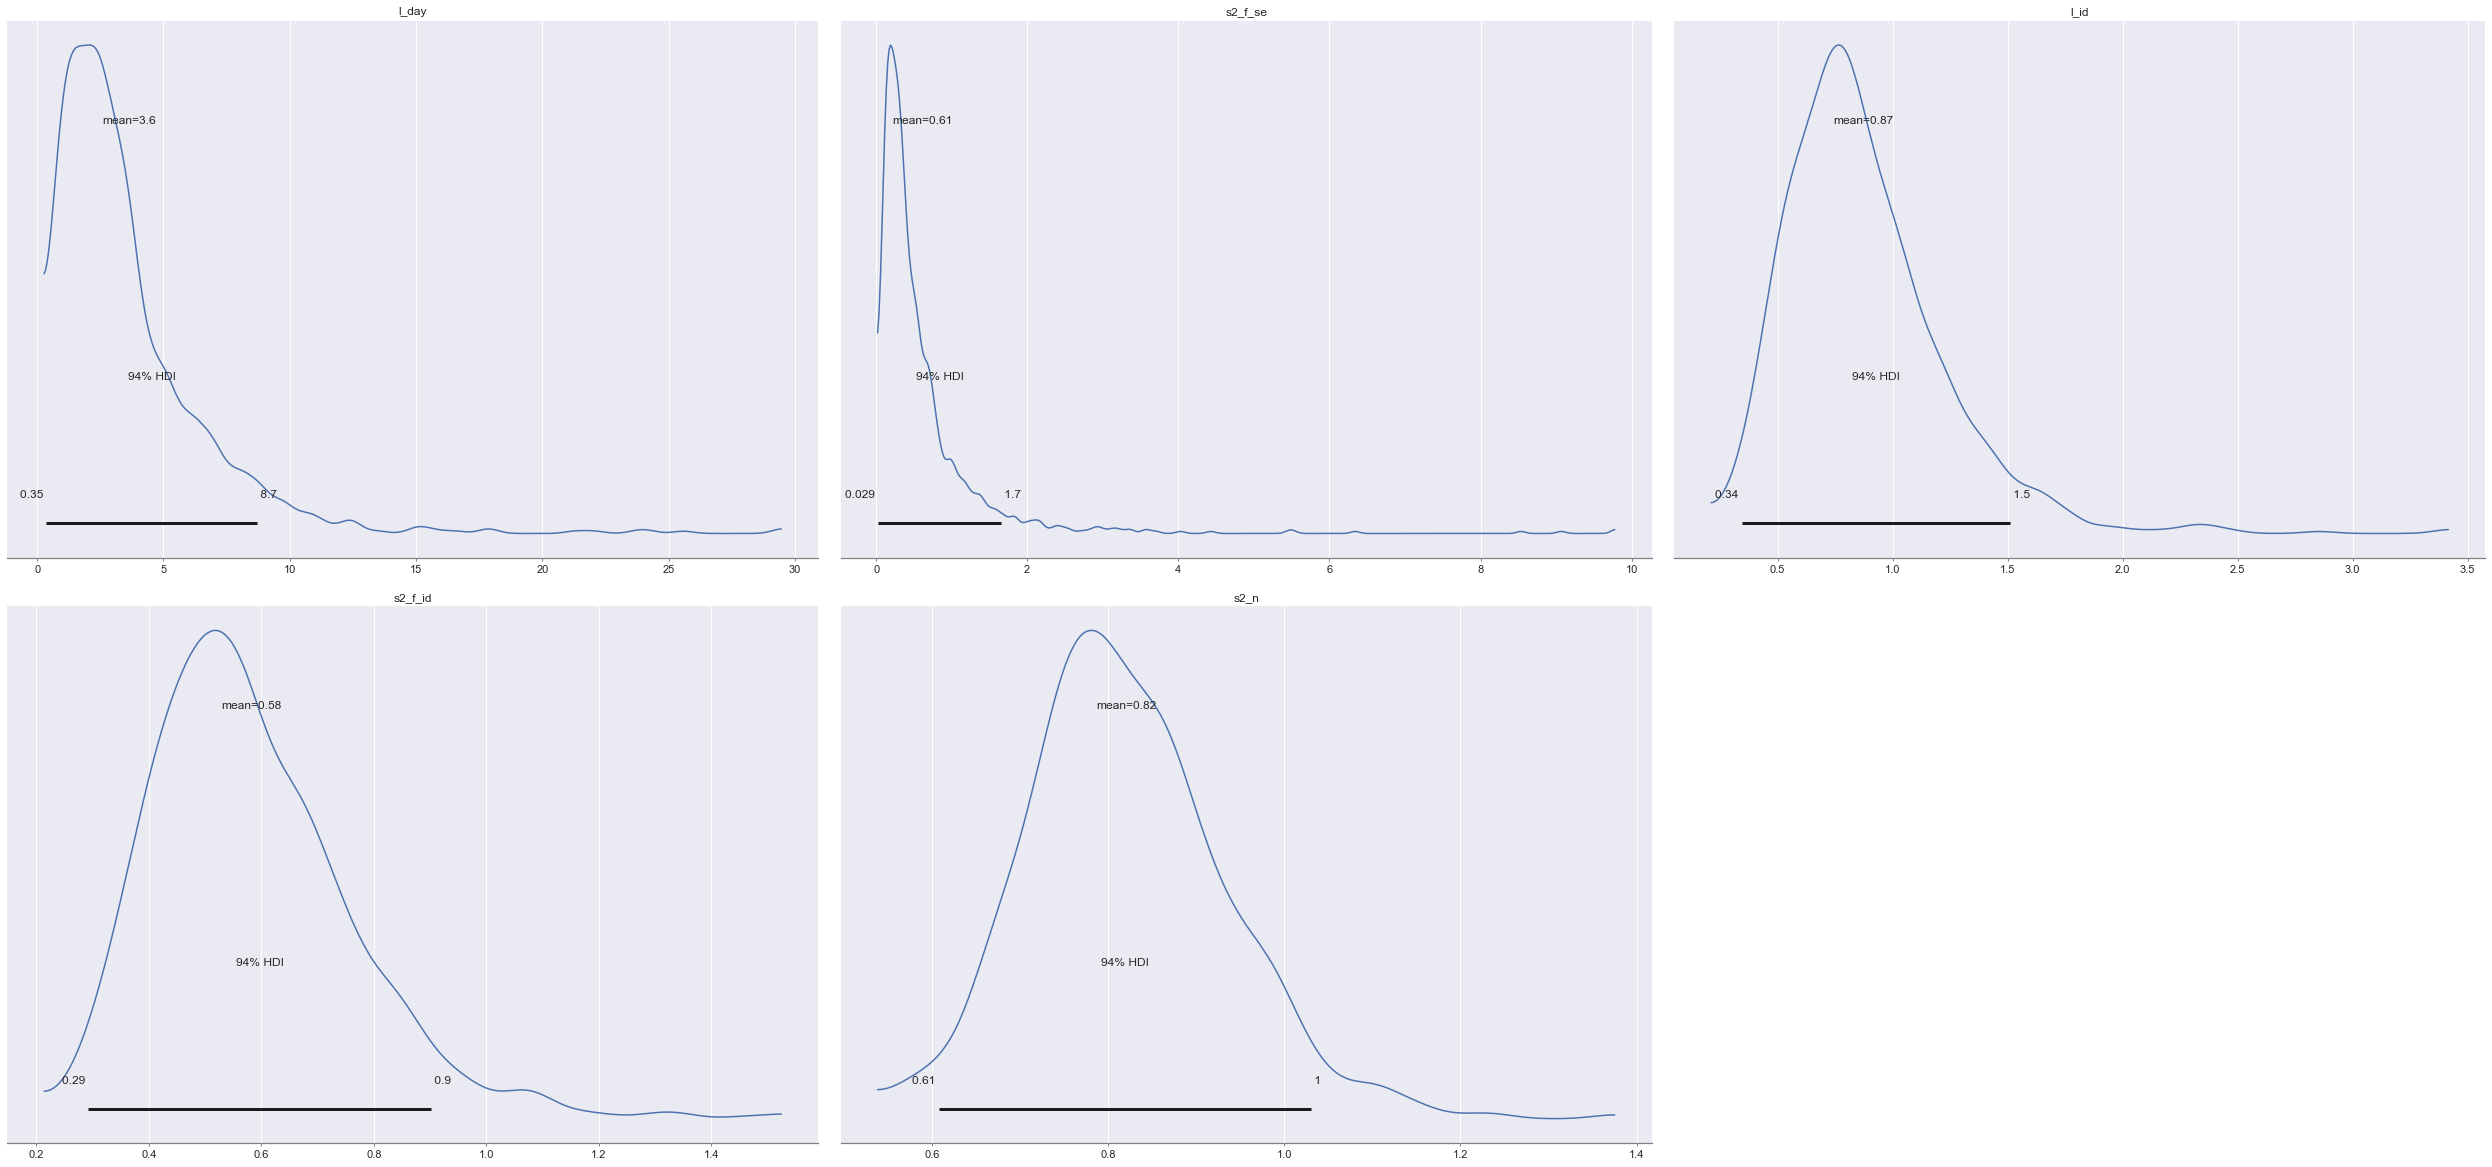

In [80]:
pm.plot_posterior(meanfield.sample(1000))

In [73]:
with mtx_model:
    svgd_approx = pm.fit(
        300,
        method="svgd",
        inf_kwargs=dict(n_particles=1000),
        obj_optimizer=pm.sgd(learning_rate=0.01))

In [62]:
# Sample from posterior
with mtx_model:
    trace = pm.sample(2000,
                      random_seed = 1,
                      target_accept = 0.9,
                      tune = 1000,
                      chains = 2,
                      cores = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s2_n, s2_f_id, l_id, s2_f_se, l_day]


ValueError: Not enough samples to build a trace.

In [36]:
pm.summary(trace)

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
l_day,3.044,3.160,0.071,7.749,0.054,0.039,3466.0,3342.0,4432.0,2534.0,1.0
s2_f_se,0.705,0.787,0.031,1.974,0.013,0.010,3426.0,3420.0,4094.0,3099.0,1.0
l_id[0],2.083,2.957,0.037,5.791,0.050,0.035,3558.0,3546.0,4286.0,2933.0,1.0
l_id[1],1.937,2.279,0.039,5.307,0.041,0.030,3133.0,2924.0,3805.0,2669.0,1.0
l_id[2],2.022,2.410,0.045,5.527,0.039,0.029,3882.0,3468.0,4537.0,3372.0,1.0
l_id[3],2.035,2.345,0.039,5.671,0.039,0.031,3652.0,2899.0,4388.0,2645.0,1.0
l_id[4],1.059,1.248,0.037,2.761,0.021,0.015,3494.0,3494.0,3955.0,3065.0,1.0
l_id[5],1.882,2.155,0.041,5.321,0.035,0.025,3842.0,3652.0,5055.0,3314.0,1.0
l_id[6],0.656,0.573,0.043,1.451,0.011,0.008,2643.0,2592.0,3078.0,2546.0,1.0
l_id[7],1.389,1.848,0.035,3.952,0.038,0.029,2315.0,2102.0,3225.0,2774.0,1.0


/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


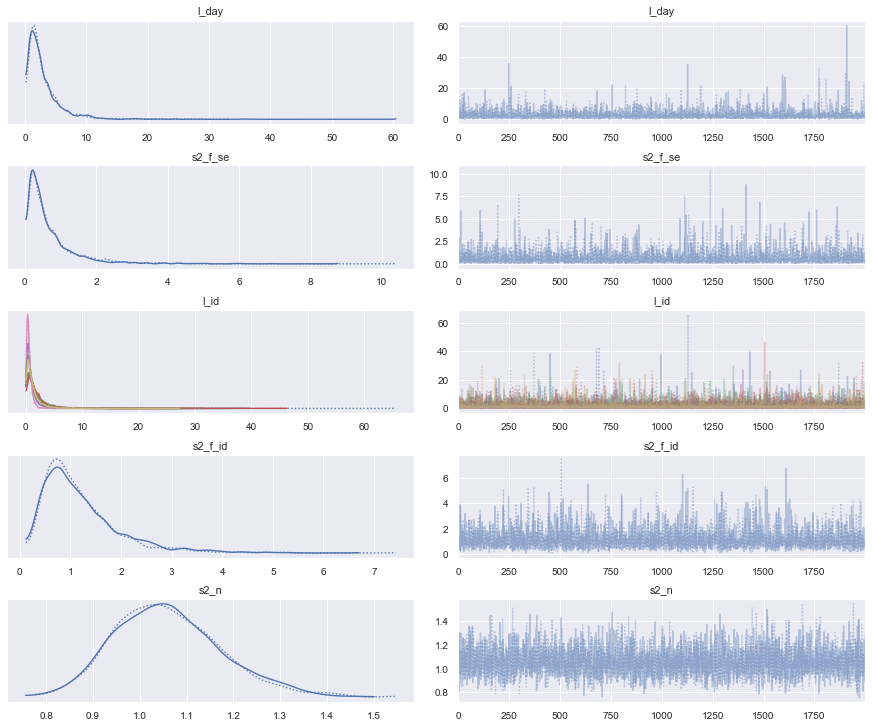

In [37]:
# Plot posterior
pm.traceplot(trace);

/Users/allen/opt/anaconda3/envs/gp/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


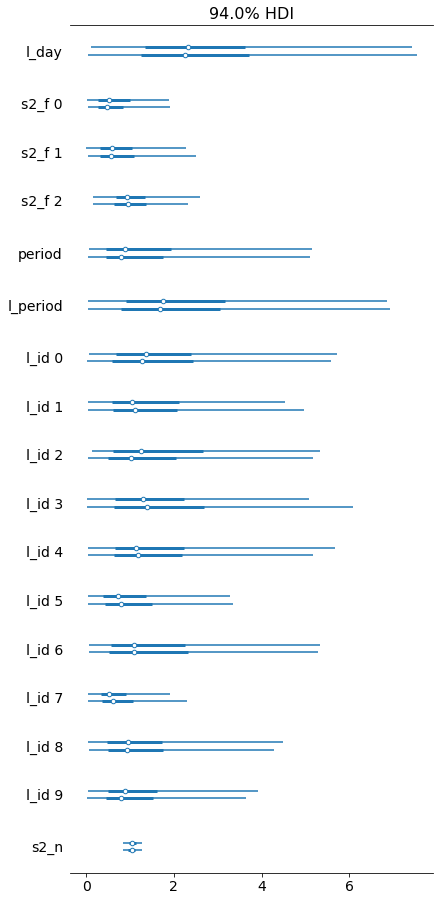

In [309]:
pm.forestplot(trace);

In [310]:
# add the GP conditional to the model, given the new X values
with model:
    # First get the conditional function values given posterior
    f_pred = gp.conditional('f_pred', X_new)
    
    # Now get the predictive distribution
    pred_samples = pm.sample_posterior_predictive(trace, 
                                                  var_names = ['f_pred'],
                                                  random_seed = 1)

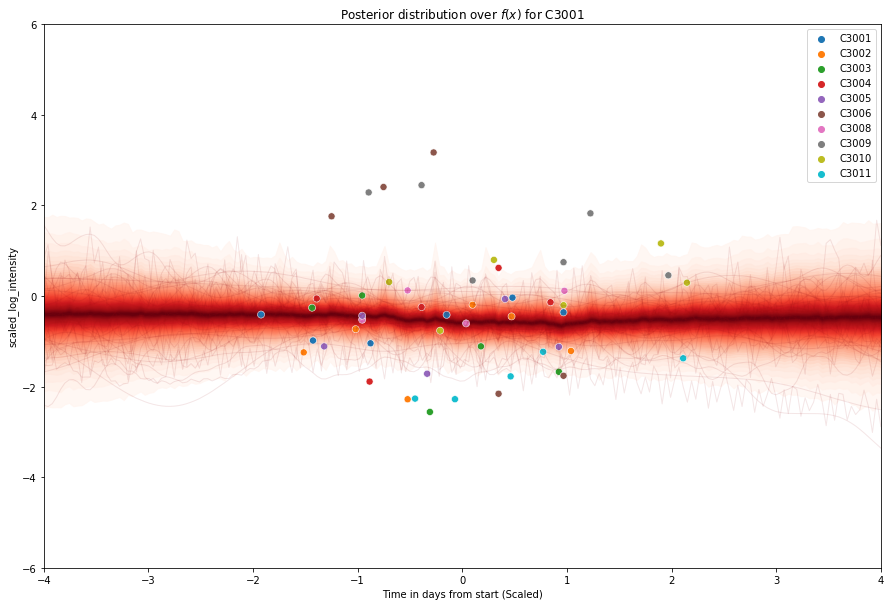

In [314]:
# Plotting 
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             pred_samples["f_pred"], 
             X_new[:,0])

# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                s = 50);

# Specify labels and axes
plt.xlabel("Time in days from start (Scaled)")
plt.ylim([-6, 6])
plt.xlim([-4, 4])
plt.title("Posterior distribution over $f(x)$ for C3001")
plt.legend();

In [300]:
# add the GP conditional to the model, given the new X values
with model:
    # First get the conditional function values given posterior
    y_pred = gp.conditional('y_pred', X_new, pred_noise = True)
    
    # Now get the predictive distribution
    y_samples = pm.sample_posterior_predictive(trace, 
                                                  var_names = ['y_pred'],
                                                  random_seed = 1)

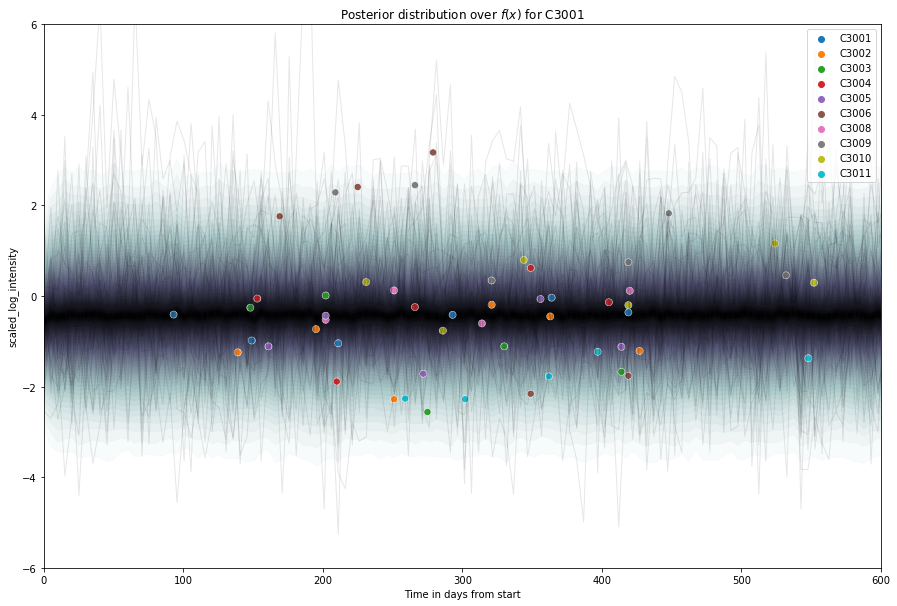

In [301]:
# Plotting PPD for observations (include noise)
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
plot_gp_dist(ax, 
             y_samples['y_pred'], 
             X_new[:,0],
             palette = 'bone_r')

# Overlay observed data
sns.scatterplot(data = df_sub.assign(id = df_sub_id.id),
                x = 'days_from_start',
                y = 'scaled_log_intensity',
                hue = 'id',
                s = 50);

# Specify labels and axes
plt.xlabel("Time in days from start")
plt.ylim([-6, 6])
plt.xlim([0, 600])
plt.title("Posterior distribution over $f(x)$ for C3001")
plt.legend();